In [85]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import glob
import time

In [86]:
from PIL import Image
from tqdm import tqdm
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist

In [87]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [88]:
(images, _), (_, _) = fashion_mnist.load_data()
images = images / 127.5 - 1.
images = np.expand_dims(images, axis = 3)
np.random.shuffle(images)

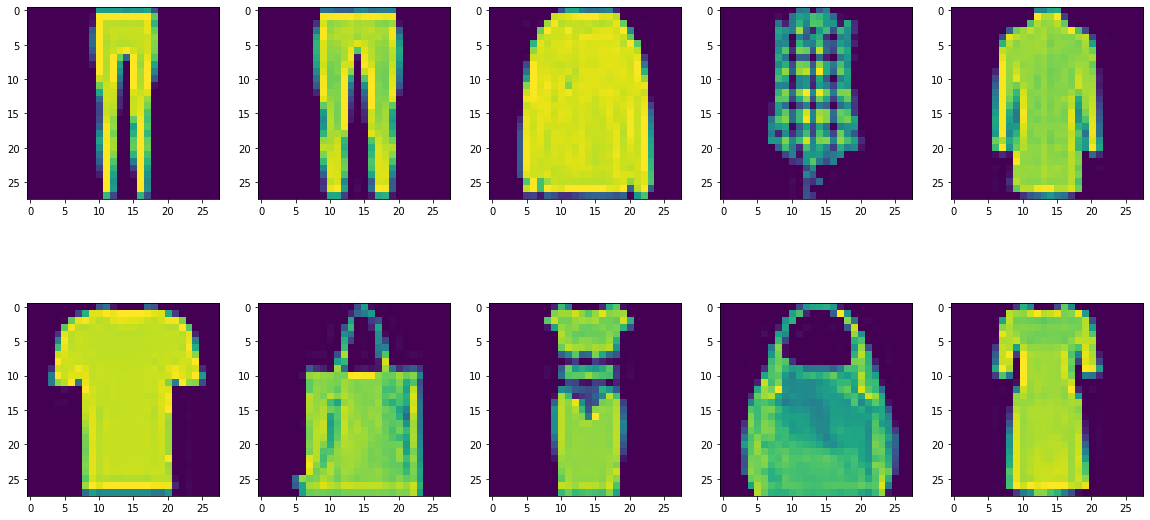

In [89]:
plt.figure(figsize = (20,10)) 
for i in range(0, len(images[:10])):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i]) 
plt.show() 

In [90]:
# Generator
generator = Sequential()

generator.add(Dense(128 * 7 * 7, activation="relu", input_dim = 100))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size = 3, padding = "same"))
generator.add(BatchNormalization(momentum = 0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size = 3, padding = "same"))
generator.add(BatchNormalization(momentum = 0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(1, kernel_size = 3, padding = "same"))
generator.add(Activation("tanh"))
generator.summary()

input_layer = Input(shape = (100,))
img = generator(input_layer)
gen_model = Model(input_layer, img)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_15 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_55 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_28 (Activation)   (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 28, 28, 128)     

In [91]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = (28, 28, 1), padding = "same"))
discriminator.add(LeakyReLU(alpha = 0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size = 3, strides = 2, padding = "same"))
discriminator.add(ZeroPadding2D(padding = ((0,1), (0,1))))
discriminator.add(BatchNormalization(momentum = 0.8))
discriminator.add(LeakyReLU(alpha = 0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size = 3, strides = 2, padding = "same"))
discriminator.add(BatchNormalization(momentum = 0.8))
discriminator.add(LeakyReLU(alpha = 0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size = 3, strides = 1, padding = "same"))
discriminator.add(BatchNormalization(momentum = 0.8))
discriminator.add(LeakyReLU(alpha = 0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))
discriminator.summary()
img = Input(shape = (28, 28, 1))
validity = discriminator(img)

disc_model = Model(img, validity)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 8, 8, 64)        

In [92]:
disc_model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.00002, beta_1 = 0.5), metrics = ['accuracy'])
disc_model.trainable = False
input_layer = Input((100,))
img = gen_model(input_layer)
gan_out = disc_model(img)
gan = Model(input_layer, gan_out)
gan.summary()
gan.compile(loss='binary_crossentropy', optimizer = Adam(lr = 0.0002, beta_1 = 0.5))

Model: "functional_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
functional_59 (Functional)   (None, 28, 28, 1)         856193    
_________________________________________________________________
functional_61 (Functional)   (None, 1)                 393729    
Total params: 1,249,922
Trainable params: 855,809
Non-trainable params: 394,113
_________________________________________________________________


 10%|▉         | 299/3000 [00:49<06:54,  6.52it/s]

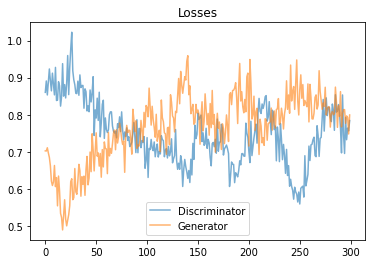

Epoch 300/3000 |   Duration: 0.35006 |  Discriminator Loss: 0.74944 |  Generator Loss: 0.76624


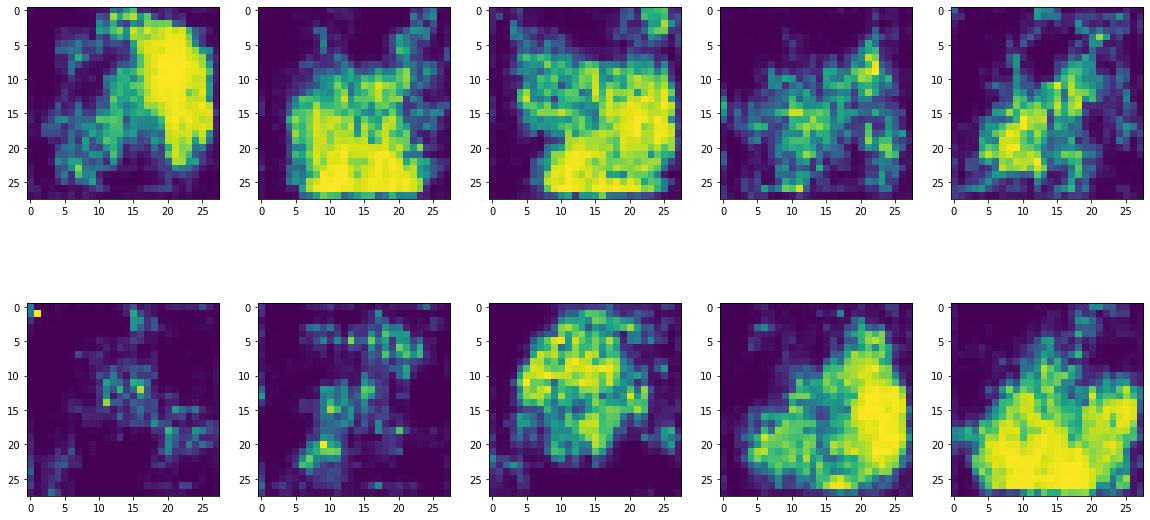

 20%|█▉        | 599/3000 [01:36<05:59,  6.67it/s]

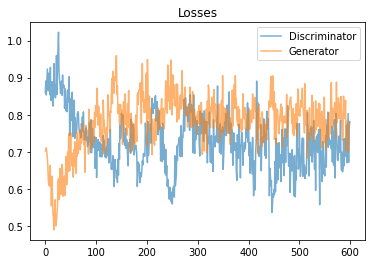

Epoch 600/3000 |   Duration: 0.33662 |  Discriminator Loss: 0.71404 |  Generator Loss: 0.80048


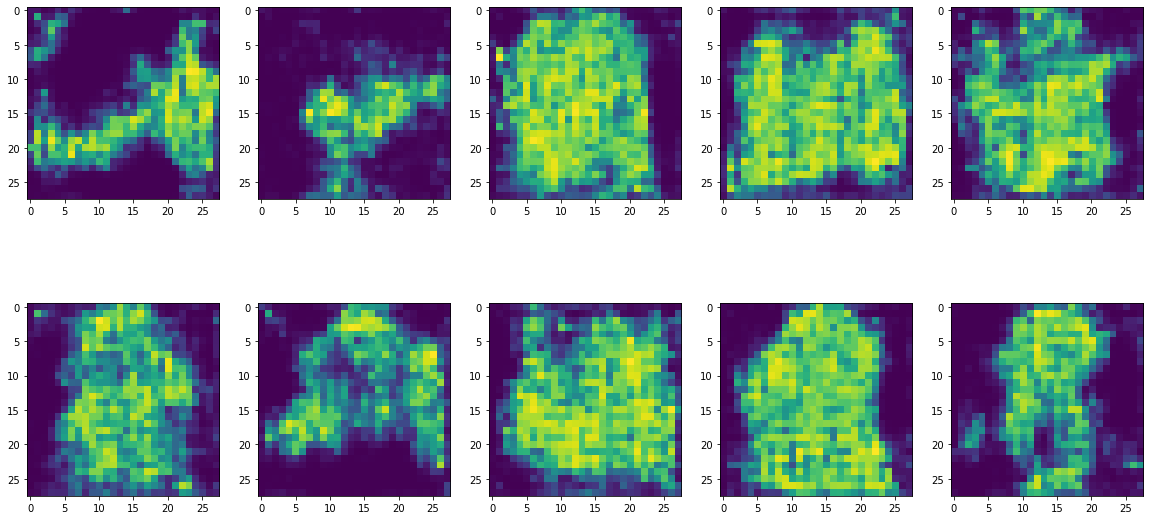

 30%|██▉       | 899/3000 [02:23<05:15,  6.67it/s]

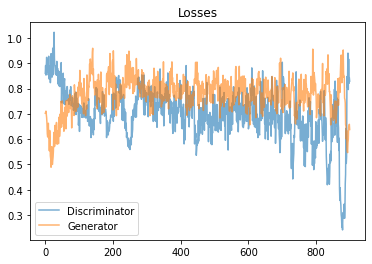

Epoch 900/3000 |   Duration: 0.44828 |  Discriminator Loss: 0.66363 |  Generator Loss: 0.77844


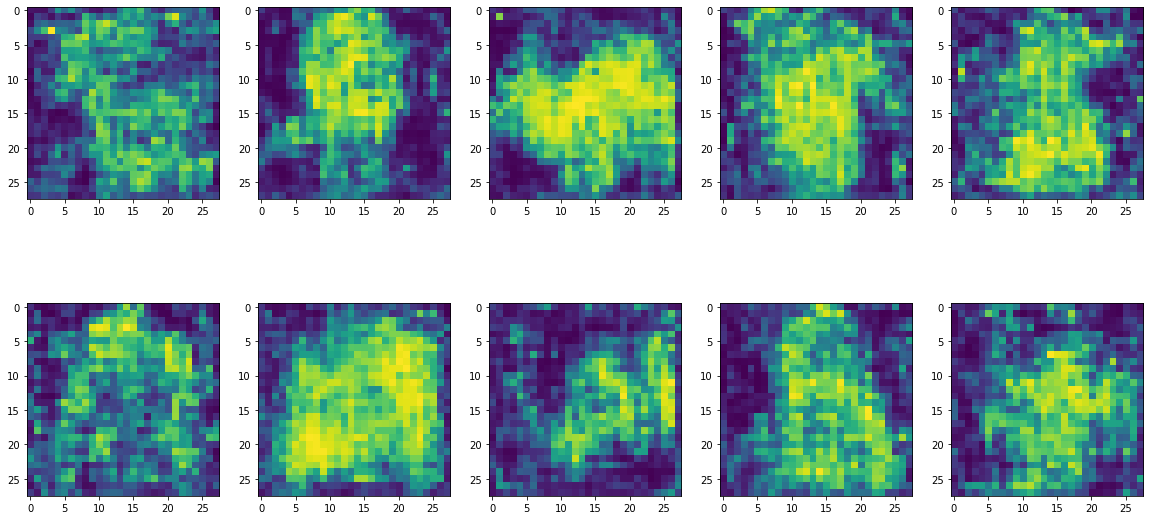

 40%|███▉      | 1199/3000 [03:11<04:30,  6.67it/s]

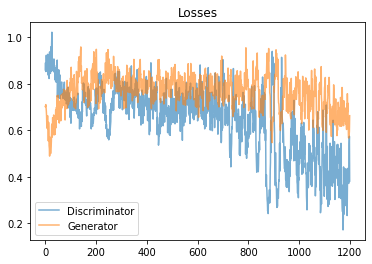

Epoch 1200/3000 |   Duration: 0.35993 |  Discriminator Loss: 0.51138 |  Generator Loss: 0.73588


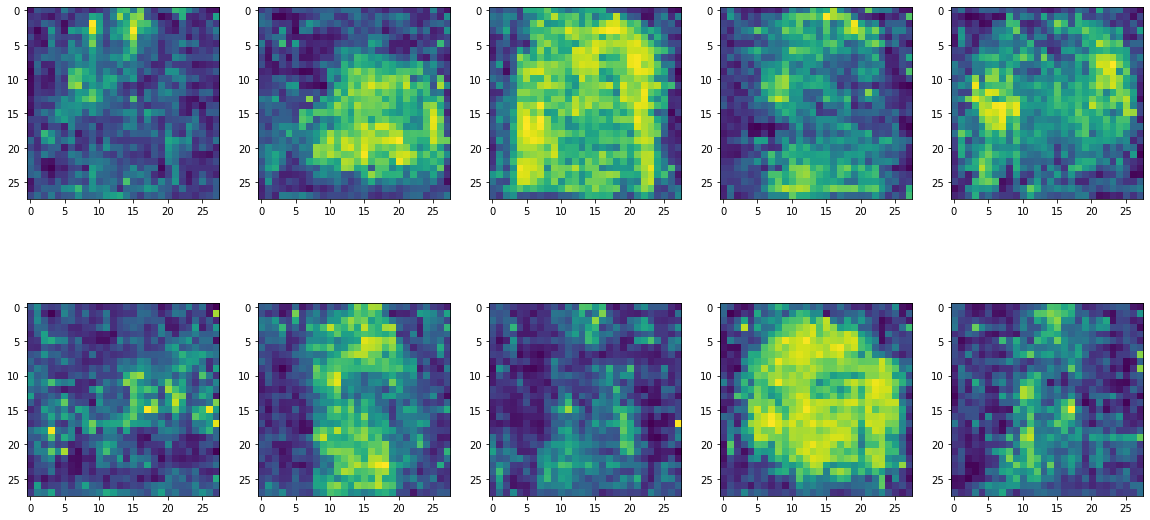

 50%|████▉     | 1499/3000 [04:00<04:09,  6.01it/s]

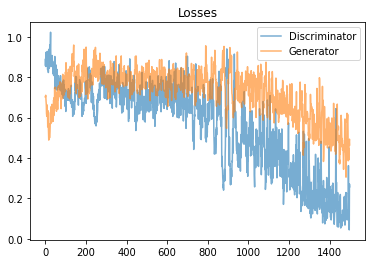

Epoch 1500/3000 |   Duration: 0.41880 |  Discriminator Loss: 0.29498 |  Generator Loss: 0.60763


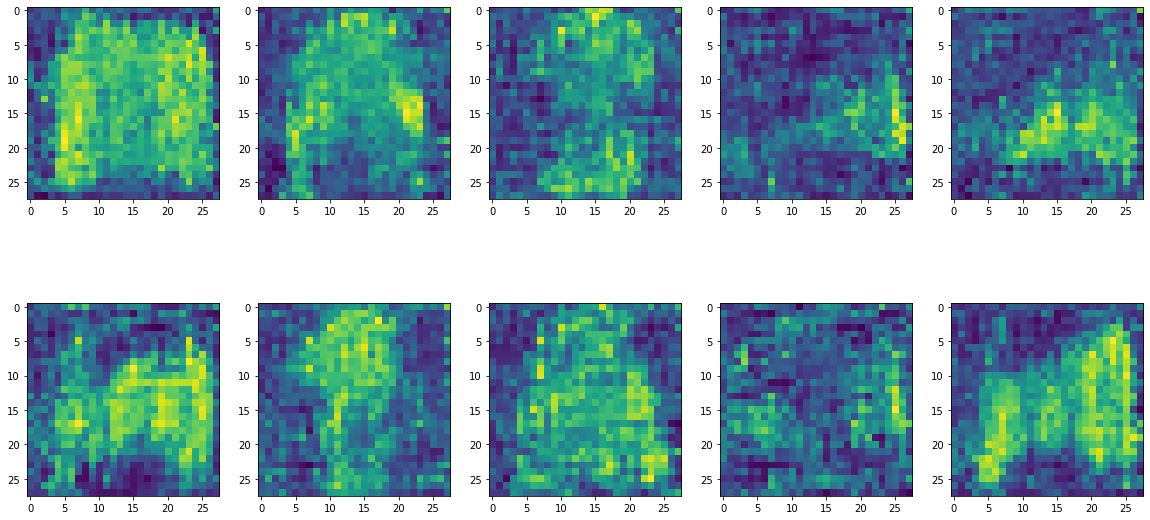

 60%|█████▉    | 1799/3000 [04:48<03:00,  6.67it/s]

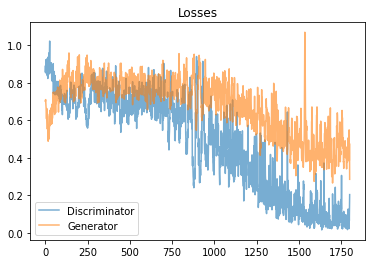

Epoch 1800/3000 |   Duration: 0.36035 |  Discriminator Loss: 0.11987 |  Generator Loss: 0.48349


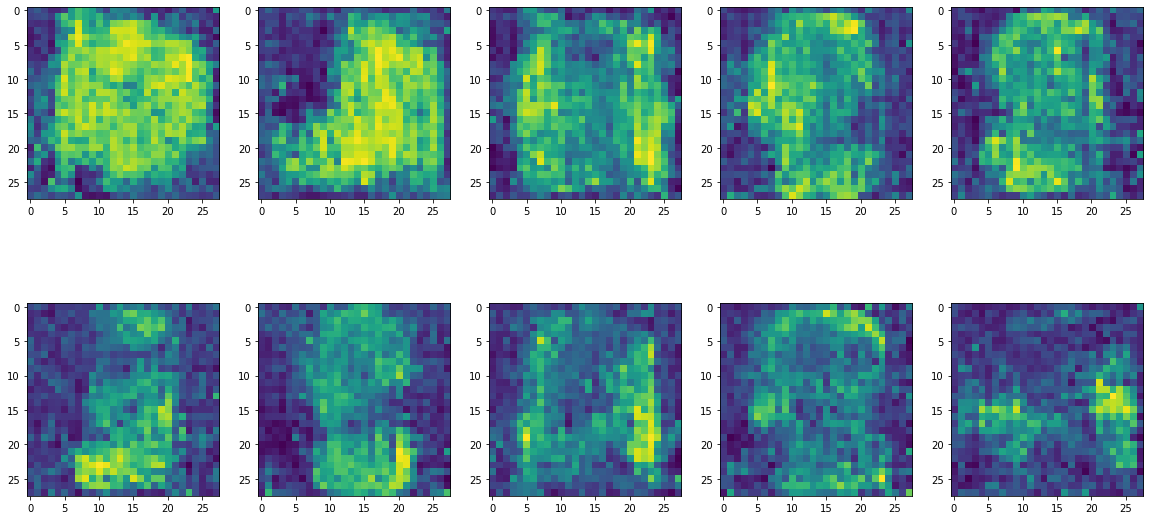

 70%|██████▉   | 2099/3000 [05:35<02:15,  6.67it/s]

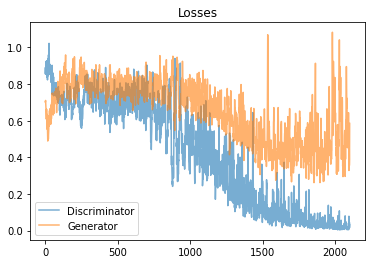

Epoch 2100/3000 |   Duration: 0.34995 |  Discriminator Loss: 0.04823 |  Generator Loss: 0.48566


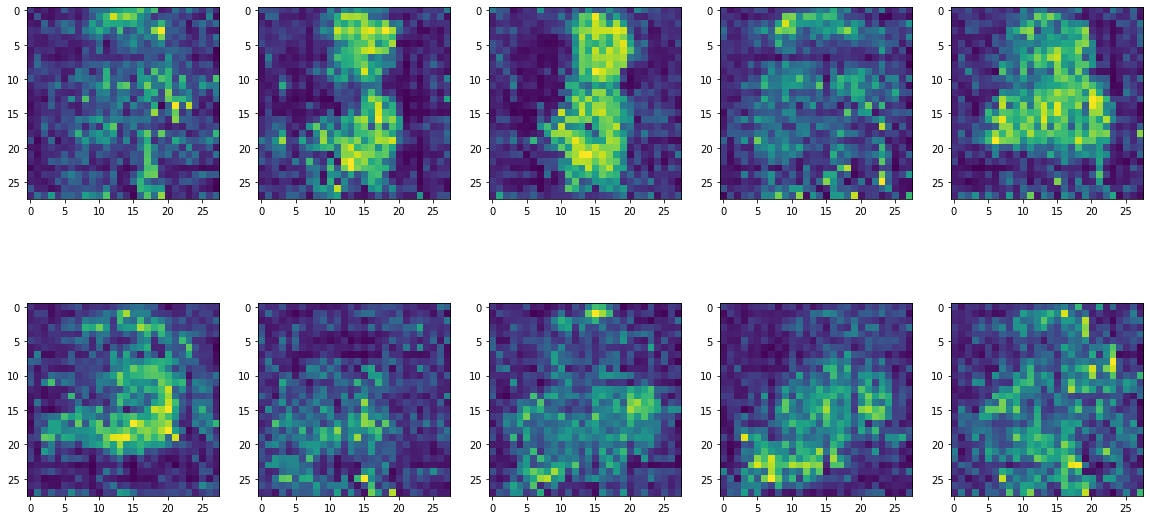

 80%|███████▉  | 2399/3000 [06:22<01:31,  6.56it/s]

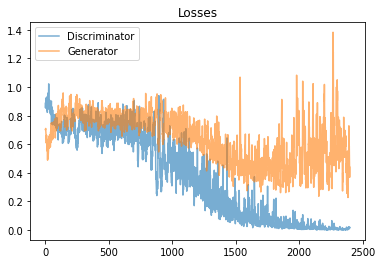

Epoch 2400/3000 |   Duration: 0.36584 |  Discriminator Loss: 0.01672 |  Generator Loss: 0.55764


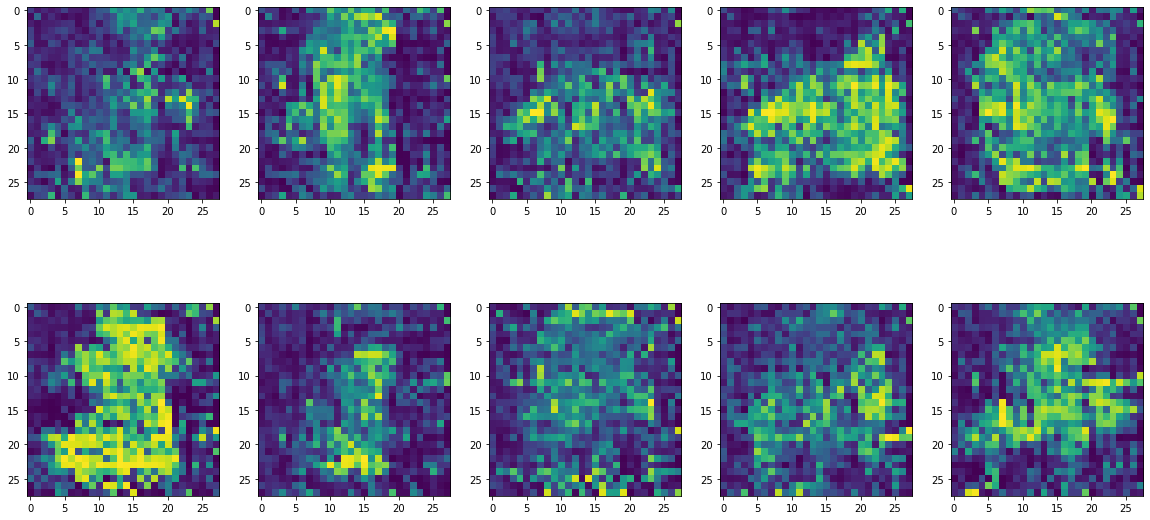

 90%|████████▉ | 2699/3000 [07:09<00:45,  6.63it/s]

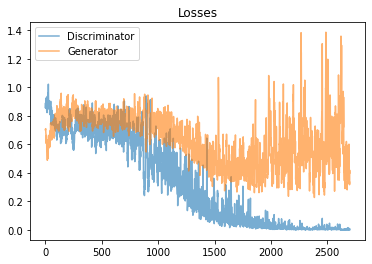

Epoch 2700/3000 |   Duration: 0.37026 |  Discriminator Loss: 0.00839 |  Generator Loss: 0.58938


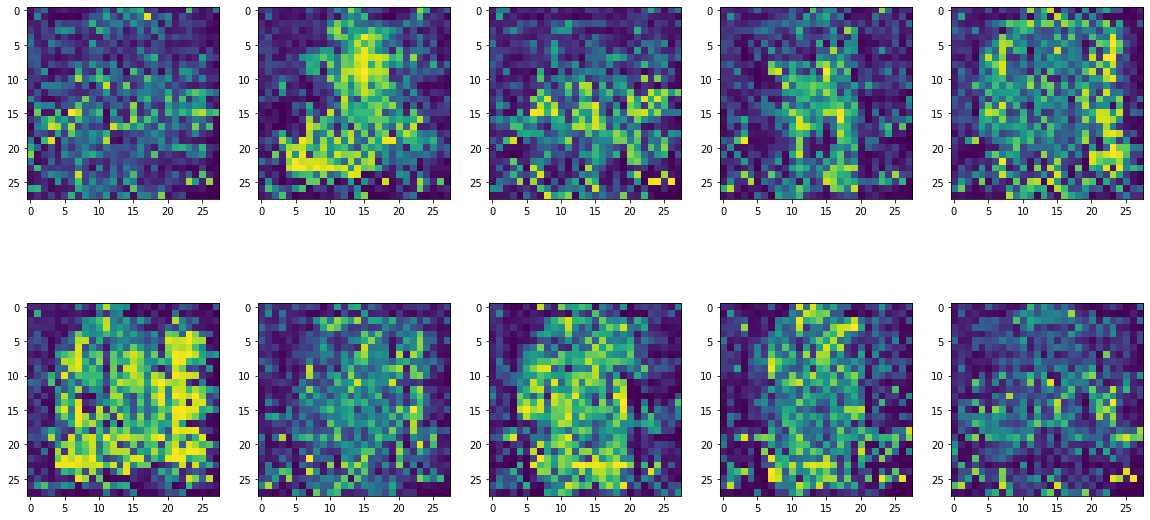

100%|█████████▉| 2999/3000 [07:57<00:00,  6.54it/s]

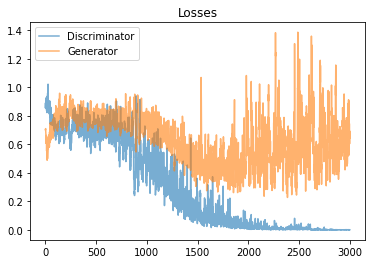

Epoch 3000/3000 |   Duration: 0.38337 |  Discriminator Loss: 0.00306 |  Generator Loss: 0.62861


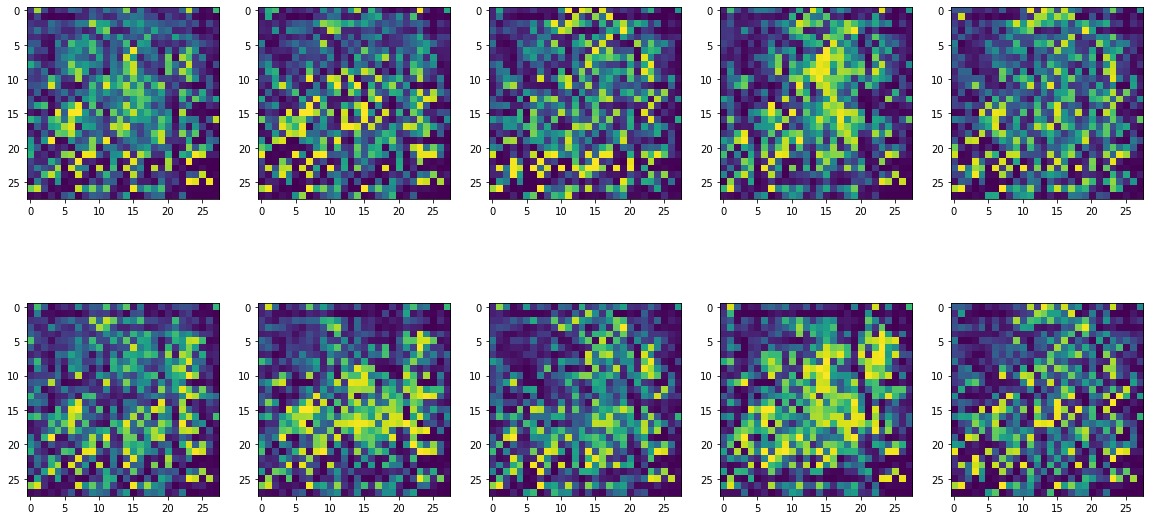

100%|██████████| 3000/3000 [07:59<00:00,  6.26it/s]


In [93]:
disc_losses = [] 
gen_losses = []
total_disc_loss = 0
total_gen_loss = 0
epochs = 3000
real_labels = np.ones((128, 1))
fake_labels = np.zeros((128, 1))

for epoch in tqdm(range(epochs)):
    epoch += 1
    start = time.time()
       
    idx = np.random.randint(0, images.shape[0], 128)
    imgs = images[idx]
    
    noise = np.random.normal(0, 1, (128, 100))
    generated_images = gen_model.predict(noise)

    d_loss_real = disc_model.train_on_batch(imgs, real_labels)
    d_loss_fake = disc_model.train_on_batch(generated_images, fake_labels)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    disc_model.trainable = False
    total_disc_loss += d_loss
    disc_losses.append(d_loss[0])
    g_loss = gan.train_on_batch(noise, real_labels)
    total_gen_loss += g_loss
    gen_losses.append(g_loss)
    
   
        
    if epoch > 0 and epoch % 300 == 0 :
        # print("saving model")
        # disc_model.save("discriminator_{}.h5".format(str(epoch)))
        # gen_model.save("generator_{}.h5".format(str(epoch)))
        # gan.save("gan_{}.h5".format(str(epoch)))
        
        fig, ax = plt.subplots()
        plt.plot(disc_losses, label = 'Discriminator', alpha = 0.6)
        plt.plot(gen_losses, label = 'Generator', alpha = 0.6)
        plt.title("Losses")
        plt.legend()
        plt.savefig("images/" + "losses_" + str(epoch) + ".png")
        plt.show()
        plt.close()
        
        minibatch_size = int(len(images) // 128)
        print("Epoch {}/{} | ".format(epoch, epochs)," Duration: {:.5f} |".format(time.time() - start)," Discriminator Loss: {:.5f} |".format(np.mean(disc_losses[-minibatch_size:]))," Generator Loss: {:.5f}".format(np.mean(gen_losses[-minibatch_size:])))
        
        samples = gen_model.predict(noise)
        sample_images = [((x + 1.0) * 127.5).astype(np.uint8) for x in samples]
        plt.figure(figsize = (20,10)) 
        for i in range(0, len(sample_images[:10])):
            plt.subplot(2, 5, i + 1)
            plt.imshow(sample_images[i]) 
        plt.savefig("images/" + "figure_" + str(epoch) + ".png")
        plt.show() 